# Introduction

This project addresses the take-home challenge for data-scientist interviewees at Ultimate Technologies, Inc. The project comprises three parts: exploratory data analysis (EDA), experiment and metrics design, and predictive modeling. 

# Exploratory Data Analysis

Starting with a set of timestamps of user logins in a particular geographic location, I will aggregate login counts based on 15-minute time intervals before visualizing and describing the results in a time-series context. Additional attention wil go to important features of demand, such as daily cycles, and data-quality issues.

In [177]:
import warnings
import json
import mpld3
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# read in dataset
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
# no missing values
print(pd.isnull(logins['login_time']).value_counts())

False    93142
Name: login_time, dtype: int64


In [3]:
# create 15-minute intervals by resampling

logins.set_index('login_time', inplace=True) #reset time stamp
logins['count'] = 1 #add units to aggregate with
logins_agg = logins.resample('15T').sum() #15-minute intervals; aggregate by summation 

In [4]:
logins_agg.head()

,count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


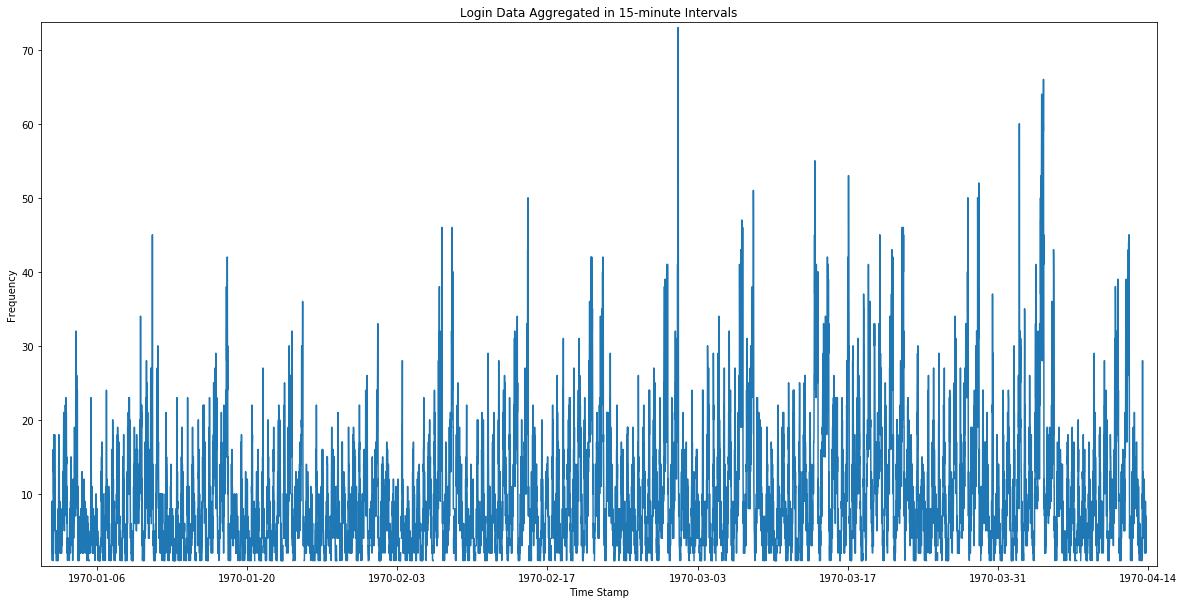

In [5]:
plt.figure(figsize=(20,10))

plt.plot(logins_agg)
plt.title('Login Data Aggregated in 15-minute Intervals')
plt.xlabel('Time Stamp')
plt.ylabel('Frequency')
plt.margins(0.01)
plt.show()

Even with the enlarged graph, it's hard to discern clear patterns. I'll next look at the data aggregated by day of the week. 

In [59]:
# daily cycles -- first aggregate by day of the week (Monday = 0; Sunday = 6)

logins_new = pd.read_json('logins.json') # read in dataset again to avoid conflicts with earlier changes to df

logins_new['day_of_week'] = logins_new['login_time'].dt.dayofweek
logins_new.head()

,login_time,day_of_week
0,1970-01-01 20:13:18,3
1,1970-01-01 20:16:10,3
2,1970-01-01 20:16:37,3
3,1970-01-01 20:16:36,3
4,1970-01-01 20:26:21,3


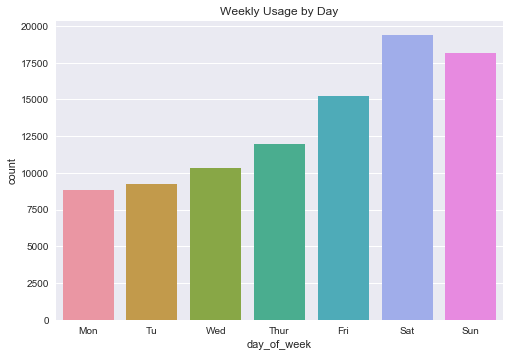

In [14]:
# plot overall usage by day

days = ['Mon', 'Tu', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

ax = sns.countplot(x = 'day_of_week', data = logins_new)
ax.set(xticklabels = days)
plt.title('Weekly Usage by Day')
plt.show() 

Usage increases over the course of the week, hitting a high on Saturdays. Overall usage is higher on weekends, too. Next, I will explore usage by time of day, showing weekdays and weekends separately. 

In [65]:
# resample -- aggregate by one-hour intervals

logins = pd.read_json('logins.json') # read in dataset again to avoid conflicts with earlier changes to df

logins.set_index('login_time', inplace=True) 
logins['count'] = 1 
logins_hr = logins.resample('60T').sum()

In [66]:
logins_hr.head()

,count
login_time,
1970-01-01 20:00:00,24.0
1970-01-01 21:00:00,9.0
1970-01-01 22:00:00,21.0
1970-01-01 23:00:00,58.0
1970-01-02 00:00:00,53.0


In [71]:
# add day of week

logins_hr['day_of_week'] = logins_hr.index.dayofweek
logins_hr.head()

,count,day_of_week
login_time,,
1970-01-01 20:00:00,24.0,3
1970-01-01 21:00:00,9.0,3
1970-01-01 22:00:00,21.0,3
1970-01-01 23:00:00,58.0,3
1970-01-02 00:00:00,53.0,4


In [95]:
 ## Here, I used 'weekend' v. 'weekday' because this labeling shows up in the plot later
logins_hr['weekend'] = np.where(logins_hr['day_of_week'] > 5, 'Weekend', 'Weekday') 
logins_hr.head() 

,count,day_of_week,weekend
login_time,,,
1970-01-01 20:00:00,24.0,3,Weekday
1970-01-01 21:00:00,9.0,3,Weekday
1970-01-01 22:00:00,21.0,3,Weekday
1970-01-01 23:00:00,58.0,3,Weekday
1970-01-02 00:00:00,53.0,4,Weekday


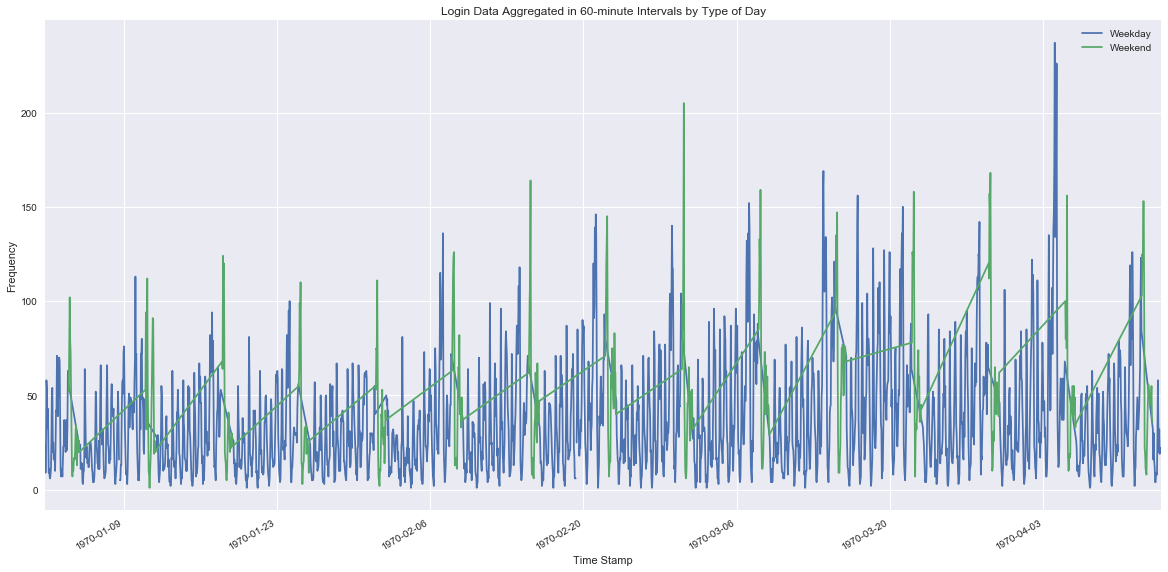

In [110]:
logins_hr.groupby(['weekend'])['count'].plot(legend=True, figsize=(20,10)) 
plt.title('Login Data Aggregated in 60-minute Intervals by Type of Day')
plt.xlabel('Time Stamp')
plt.ylabel('Frequency')
plt.show()

The plot above shows trends in weekday vs. weekend use over the time frame of interest. We can see that certain weeks, such as the one around 3/20, were comparatively busy for the entire week. I produced this one using hourly intervals, which reduce noise a bit while still displaying instructive trends. This delineation also makes it a bit easier to view activity at different times of day, as in the next plot.

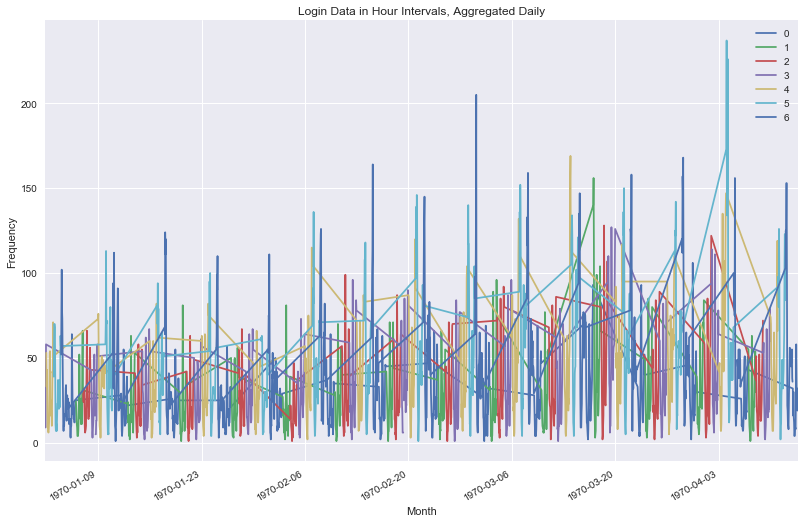

In [118]:
mpld3.enable_notebook() #enables zooming and scrolling within charts

logins_hr.groupby(['day_of_week'])['count'].plot(legend=True, figsize=(13.5,9)) 
plt.title('Login Data in Hour Intervals, Aggregated Daily')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

mpld3.disable_notebook()

The zooming and scrolling features (which appear as grey buttons if you hover over the lower-left part of the frame above) make it easier to view the behavior of individual days. The x-scale conveniently adjusts during zooming, too. Admittedly, there's some visual noise from diagonal lines connecting like days, but I think the plot is useful for now until I find a way to remove said lines. 

In [165]:
# restart df with monthly resampling

logins = pd.read_json('logins.json') # read in dataset again to avoid conflicts with earlier changes to df
logins.set_index('login_time', inplace=True) 
logins['count'] = 1 
logins_mo = logins.resample('D').sum()

logins_mo.head() 

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


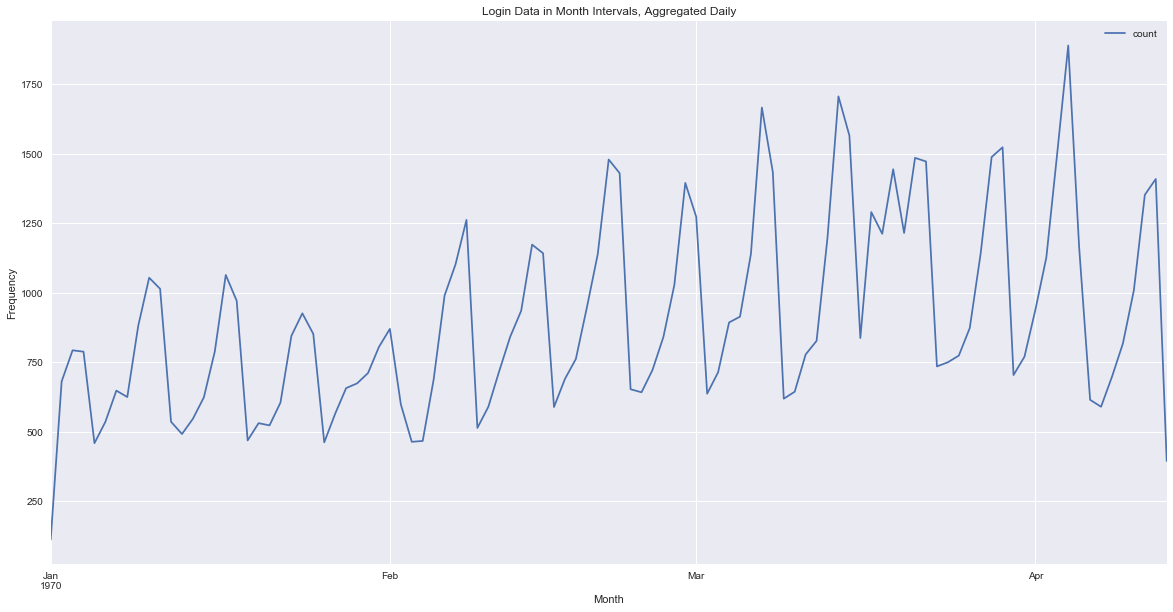

In [170]:
# plot to observe each month, with daily aggregation 
logins_mo.plot(figsize=(20,10))
plt.title('Login Data in Month Intervals, Aggregated Daily')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

There are 4-5 peaks per month, which likely coincide with weekends. But the peaks increase noticeably across the time frame of interest, and the valleys increase a bit as well. 

## Experiment and Metrics Design 

In response to the experiment of reimbursing toll costs to encourage drivers to serve both Gotham and Metropolis, I will address a few topics:

- A key measure of success in encouraging drivers to serve both cities

- A practical experiment -- including implementation, statistical tests, and interpretation of results -- to compare the effectiveness of the proposed change and make appropriate recommendations 

1. The key measure of success should be oriented toward having drivers serve both cities. Presumably, this outcome would obviate the need for additional drivers in accommodating the alternating weekday demands of the two cities. With that information in mind, a key metric would be the increase in revenue per driver while taking into account a driver's "home" city and time of day in the other city. More specifically, I recommend looking at the increase in weekday revenue per driver for Gotham drivers in Metropolis during the day, and conversely looking at the increase in weekday revenue per driver for Metropolis drivers in Gotham at night. 

    I recommend this pair of metrics because it will best capture the increases in revenue (which would the need to be 
    compared against increased costs from tolls, of course) streams that stem from encouraging drivers to cover their 
    opposite city during its peak hours. 

2a. Implementing an experiment to compare the effectiveness of the proposed change would entail:

- Setting parameters around toll reimbursements. If the aim of the change is to improve driver supply with respect to the counterbalancing demands of each city, the reimbursements should cover only those time periods and directions of interest to properly incentivize drivers. So toll reimbursement should not be offered on weekends. In fact, that step may help keep supply and demand balanced within each city on weekends. 

- Monitoring and collecting data. In order to use the metric described above, I would need to track the appropriate data pertaining to revenue, location, and "home" city of each driver. 

- Setting a start and end point for the experiment. I would run the experiment for two separate sets of two weeks, ideally during different seasons of the year while avoiding irregularities such as holidays that may alter demand. These parameters would ideally create a large enough data set for statistical inference that is fairly representative of different seasonal patterns in demand. I would recommend longer time frames if not enough data is generated during the recommended frames. 

2b. Statistical tests

- To verify the significance of observed outcomes in the experiment, I would use a paired t-test for means. Using data for average revenue for drivers before and after the experiment, this test would help determine if there was a significant difference in driver revenue before and during the experiment. 

- I would also use a test for independence (such as Fisher's Exact) to look for a relationship between the number of drivers in each city and whether or not tolls were being reimbursed. Because of the nature of demand, I would take snapshots of data during weekdays and weeknights (but not weekends) and perform separate tests for each time of day. 

2c. Recommendations and Interpretation of Results

- From the experiment itself, I would examine data pertaining to the suggested metric. If the data indicated that drivers were cross-covering opposite cities as desired, I would proceed to looking at results from statistical tests.


- For the statistical tests, I would interpret results of the t-test as indicating whether or not any observed difference in mean revenue was due to chance. If it appeared not to be due to chance, I'd discuss potential causes with city teams based on their knowledge. I would use the exact test in a similar fashion in assessing a relationship between toll reimbursement and driver presence in each city. 

- If the above steps pointed toward a real effect from the proposed change around tolls, then I would recommend a longer-term implementation of the change. However, if the costs of doing so were not too high, I would continue to monitor the data and test results to ensure that the results hold over a longer period of time. 

## Predictive Modeling

Using a dataset with several features that was provided by Ultimate Technologies, I will produce a predictive model to evaluate rider retention. The results will help identify important factors in predicting rider retention and offer insight into suggested courses of action.

In [207]:
# read in json dataset and create dataframe
udc = open('ultimate_data_challenge.json')
riders = pd.DataFrame(json.load(udc))
udc.close()

riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [186]:
#check for variables with missing values
print(riders.isnull().any())

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool


In [197]:
print('Percent Missing by Variable')
print('avg rating by driver: {}' .format(riders.avg_rating_by_driver.isnull().sum() / len(riders)))
print('avg rating of driver: {}' .format(riders.avg_rating_of_driver.isnull().sum() / len(riders)))
print('phone: {}' .format(riders.phone.isnull().sum() / len(riders)))

Percent Missing by Variable
avg rating by driver: 0.00402
avg rating of driver: 0.16244
phone: 0.00792


The percentages of missing data are fairly low within affected variables, so I will remove rows from the dataframe with missing values. Average rating of driver has a comparatively high percentage, but because it's a continuous variable, checking the relationship between missing values (essentially) a category with retention is a cumbersome process. With only 16% of the data missing for the variable, the investigation may not be worthwhile now but may be worth keeping in mind during final conclusions.

In [206]:
# remove rows affected by missingness
riders_full = riders.dropna(how='any') 

0.8289


In [224]:
warnings.filterwarnings('ignore') #ignore warning (one would come from not using .loc below)

riders_full['last_trip_date'] = pd.to_datetime(riders_full['last_trip_date'])
riders_full['signup_date'] = pd.to_datetime(riders_full['signup_date'])

print(riders_full.dtypes)

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
ultimate_black_user                 bool
weekday_pct                      float64
dtype: object


In [230]:
#create variable indicating if user still active during 6th month in system

riders_full['duration'] = riders_full['last_trip_date'].sub(riders_full['signup_date'], axis=0)
riders_full.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,duration
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47 days
